Some libraries to import

In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import GRU, Dropout, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

Choosing to work with the GPU for faster training

In [50]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
    except RuntimeError as e:
        print(e) 

Importing data

In [51]:
commands = []

with open('data.txt', 'r') as file:
    for line in file:
      if line:
        commands.append(line.strip())

# commands

Tokenization

In [52]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(commands)

Sequencing

In [53]:
sequences = tokenizer.texts_to_sequences(commands)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

Input Output sequences

In [54]:
input_sequences = []
target_sequences = []

for seq in sequences:
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i])
        target_sequences.append(seq[i])

Padding

In [55]:
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = np.array(target_sequences)

Train_text spliting

In [56]:
x_train, x_test, y_train, y_test = train_test_split(input_sequences,target_sequences, test_size=0.2)

Parameter loading

In [57]:
import configparser
################
# reading 
################
config = configparser.ConfigParser()
config.read('best_hyperparameters.ini')

# Access hyperparameters
embedding_dim = config.getint('Hyperparameters', 'embedding_dim')
gru_units = config.getint('Hyperparameters', 'gru_units')
dropout_rate = config.getfloat('Hyperparameters', 'dropout_rate')
learning_rate = config.getfloat('Hyperparameters', 'learning_rate')
batch_size = config.getint('Hyperparameters', 'batch_size')
top_k = config.getint('Hyperparameters', 'top_k')
activation = config.get('Hyperparameters', 'activation')
activation

'sigmoid'

Model building

In [58]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_len),
    GRU(gru_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(vocab_size, activation=activation)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss='sparse_categorical_crossentropy', 
    metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=top_k)])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Limiting the usage of the gpu

In [59]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
#   except RuntimeError as e:
#     print(e)

Fitting to data

In [60]:
history = model.fit(x_train, y_train, epochs=150, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))

Epoch 1/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.2047 - sparse_top_k_categorical_accuracy: 0.1571 - val_loss: 5.1917 - val_sparse_top_k_categorical_accuracy: 0.2793
Epoch 2/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.8836 - sparse_top_k_categorical_accuracy: 0.3264 - val_loss: 4.5286 - val_sparse_top_k_categorical_accuracy: 0.4032
Epoch 3/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.2070 - sparse_top_k_categorical_accuracy: 0.4323 - val_loss: 4.0092 - val_sparse_top_k_categorical_accuracy: 0.4720
Epoch 4/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.6317 - sparse_top_k_categorical_accuracy: 0.5319 - val_loss: 3.5756 - val_sparse_top_k_categorical_accuracy: 0.5530
Epoch 5/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.2460 - sparse_top_k_categorical_accuracy: 0.5885 - val_loss: 3.2760 - val_sparse_top_k_categorical_accuracy: 0.6075
Epoch 6/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.8726 - sparse_top_k_categorical_accuracy: 

Extraction statistics

In [61]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_top_k_categorical_accuracy']
val_accuracy = history.history['val_sparse_top_k_categorical_accuracy']

epochs = range(1, len(train_loss) + 1)

Graphs

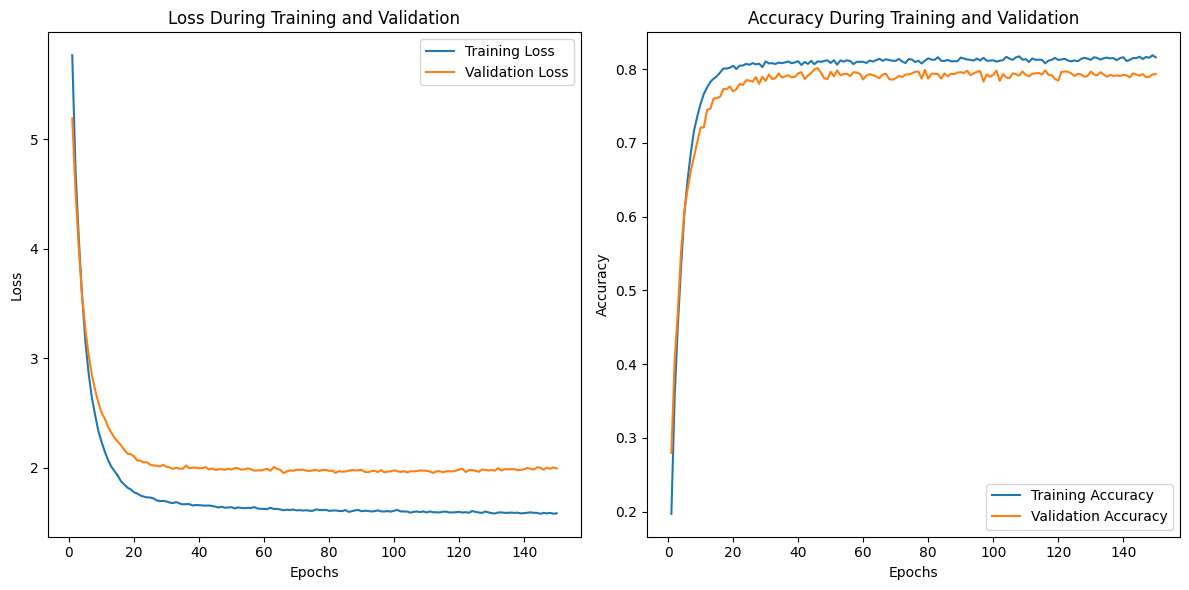

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Model evaluation

In [63]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9412 - sparse_top_k_categorical_accuracy: 0.7894
Test Loss: 1.991642713546753
Test Accuracy: 0.7930682897567749


Saving the model

In [64]:
model.save("gru_model.keras")

Saving the tokenizer

In [65]:
import pickle

with open("gru_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)